In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
from bempp.api.linalg import lu
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
k = 4
h = 0.1
deg = 5

d0 = [0,0,-1] # wave's travel direction
p0 = [1,0,0] # polarization 

In [3]:
rotation_angle = np.pi/9
rotation_mat = [[1,0,0],[0, np.cos(rotation_angle), -np.sin(rotation_angle)],[0,np.sin(rotation_angle), np.cos(rotation_angle)]]

origin_grid = bempp.api.shapes.sphere(r=0.2, origin=[0,0,0],h = h)
origin_grid_vert = origin_grid.vertices

grid_vert = np.zeros((3, origin_grid_vert.shape[1]))
for i in range(grid_vert.shape[1]):
    grid_vert[:,i] = rotation_mat @ origin_grid_vert[:,i]
    
grid = bempp.api.Grid(grid_vert, origin_grid.elements)

div_space = bempp.api.function_space(grid, "RWG", 0)
curl_space = bempp.api.function_space(grid, "SNC", 0)

In [4]:
origin_unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
origin_vert_unit_sphere = origin_unit_sphere.vertices

vert_unit_sphere = np.zeros((3, origin_vert_unit_sphere.shape[1]))
for i in range(vert_unit_sphere.shape[1]):
    vert_unit_sphere[:,i] = rotation_mat@origin_vert_unit_sphere[:,i]
    
unit_sphere = bempp.api.Grid(vert_unit_sphere,origin_unit_sphere.elements)
    
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

In [5]:
#bempp.api.export('origin_sphere.msh', grid = origin_unit_sphere)
#bempp.api.export('rotated_sphere.msh', grid = unit_sphere)

In [6]:
elec = bempp.api.operators.boundary.maxwell.electric_field(div_space, div_space, curl_space, k)
elec_far = bempp.api.operators.far_field.maxwell.electric_field(div_space, vert_unit_sphere, k)

mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere, space_unit_sphere, space_unit_sphere).weak_form().A

In [7]:
def sph_b(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*k*r))*scipy.special.jv(q+0.5, k*r)  

def sph_b_dr(q,x):
    r = np.linalg.norm(x)
    return k*(sph_b(q-1,x) - ((q+1)/(k*r))*sph_b(q,x))

def sph(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)
    
def sph_dazi(p, q, x):
    return 1j * p * sph(p, q, x)

def sph_dpolar(p, q, x):
    polar = np.arccos(x[2]/np.linalg.norm(x))
    azimuth = np.arctan2(x[1],x[0])
    y1 = sph(p, q, x)
    y3 = sph(-p, q, x)
    
    if abs(p) == q and p >= 0:
        return (p / np.tan(polar)) * y1 
    elif abs(p) != q and p >= 0:
        y2 = sph(p + 1, q, x)
        return (p / np.tan(polar)) * y1 - np.sqrt((q - p) * (q + p + 1)) * np.exp(-1j * azimuth) * y2
    elif abs(p) == q and p < 0:
        return ((-1)**p) * (-p / np.tan(polar)) * y3 * np.exp(1j*2*p*azimuth)
    elif abs(p) != q and p < 0:
        y4 = sph(-p + 1, q, x)
        return  ((-1)**p) * ((-p / np.tan(polar)) * y3 - np.sqrt((q - (-p)) * (q + (-p) + 1)) * np.exp(-1j * azimuth) * y4) * np.exp(1j*2*p*azimuth)

In [8]:
def sph_wf_M(p,q,x):
    r = np.linalg.norm(x)
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/r)
    
    grad_sph = [sph_dpolar(p,q,x)*np.cos(polar)*np.cos(azimuth) - sph_dazi(p,q,x)*np.sin(azimuth)/np.sin(polar), 
                sph_dpolar(p,q,x)*np.cos(polar)*np.sin(azimuth) + sph_dazi(p,q,x)*np.cos(azimuth)/np.sin(polar),
               -sph_dpolar(p,q,x)*np.sin(polar)]
    hat_x = [np.sin(polar)*np.cos(azimuth), np.sin(polar)*np.sin(azimuth), np.cos(polar)]
    
    return sph_b(q,x)*np.cross(grad_sph, hat_x)

def sph_wf_N(p,q,x):
    r = np.linalg.norm(x)
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/r)
    
    grad_sph = [sph_dpolar(p,q,x)*np.cos(polar)*np.cos(azimuth) - sph_dazi(p,q,x)*np.sin(azimuth)/np.sin(polar), 
                sph_dpolar(p,q,x)*np.cos(polar)*np.sin(azimuth) + sph_dazi(p,q,x)*np.cos(azimuth)/np.sin(polar),
               -sph_dpolar(p,q,x)*np.sin(polar)]
    hat_x = [np.sin(polar)*np.cos(azimuth), np.sin(polar)*np.sin(azimuth), np.cos(polar)]
    
    
    part_1 = [(q*(q+1)/r)*sph_b(q,x)*sph(p,q,x)*hat_x[0], 
             (q*(q+1)/r)*sph_b(q,x)*sph(p,q,x)*hat_x[1], 
             (q*(q+1)/r)*sph_b(q,x)*sph(p,q,x)*hat_x[2]]
    
    part_2 = [(1/r)*(sph_b(q,x)+r*sph_b_dr(q,x))*grad_sph[0], 
                (1/r)*(sph_b(q,x)+r*sph_b_dr(q,x))*grad_sph[1],
               (1/r)*(sph_b(q,x)+r*sph_b_dr(q,x))*grad_sph[2]]
    
    return [(1/(1j*k))*(part_1[0]+part_2[0]), (1/(1j*k))*(part_1[1]+part_2[1]), (1/(1j*k))*(part_1[2]+part_2[2])]

In [9]:
def U_pq(p, q, x):
    r = np.linalg.norm(x)
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/r)
    
    return [sph_dpolar(p,q,x)*np.cos(polar)*np.cos(azimuth) - sph_dazi(p,q,x)*np.sin(azimuth)/np.sin(polar), 
            sph_dpolar(p,q,x)*np.cos(polar)*np.sin(azimuth) + sph_dazi(p,q,x)*np.cos(azimuth)/np.sin(polar),
            -sph_dpolar(p,q,x)*np.sin(polar)]
def V_pq(p, q, x):
    r = np.linalg.norm(x)
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/r)
    
    grad_sph = [sph_dpolar(p,q,x)*np.cos(polar)*np.cos(azimuth) - sph_dazi(p,q,x)*np.sin(azimuth)/np.sin(polar), 
                sph_dpolar(p,q,x)*np.cos(polar)*np.sin(azimuth) + sph_dazi(p,q,x)*np.cos(azimuth)/np.sin(polar),
               -sph_dpolar(p,q,x)*np.sin(polar)]
    hat_x = [np.sin(polar)*np.cos(azimuth), np.sin(polar)*np.sin(azimuth), np.cos(polar)]
    
    return np.cross(hat_x, grad_sph)

In [ ]:
coeff_S_V_1 = []
coeff_S_U_1 = []
for q in range(1, deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def V_fun_1(x,n,domain_index,result):
            with objmode():
                result[0] = V_pq(p,q,x)[0]
        V_grid_1 = bempp.api.GridFunction(space_unit_sphere,fun = V_fun_1)
        coeff_S_V_1.append(np.conj(V_grid_1.coefficients)* (-k) *((1j)**(q+1))/(q*(q+1)))
        
        @bempp.api.complex_callable
        def U_fun_1(x,n,domain_index,result):
            with objmode():
                result[0] = U_pq(p,q,x)[0]
        U_grid_1 = bempp.api.GridFunction(space_unit_sphere,fun = U_fun_1)
        coeff_S_U_1.append(np.conj(U_grid_1.coefficients)* ((1j)**q)/(q*(q+1)))

In [ ]:
coeff_S_V_2 = []
coeff_S_U_2 = []
for q in range(1, deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def V_fun_2(x,n,domain_index,result):
            with objmode():
                result[0] = V_pq(p,q,x)[1]
        V_grid_2 = bempp.api.GridFunction(space_unit_sphere,fun = V_fun_2)
        coeff_S_V_2.append(np.conj(V_grid_2.coefficients)* (-k) *((1j)**(q+1))/(q*(q+1)))
        
        @bempp.api.complex_callable
        def U_fun_2(x,n,domain_index,result):
            with objmode():
                result[0] = U_pq(p,q,x)[1]
        U_grid_2 = bempp.api.GridFunction(space_unit_sphere,fun = U_fun_2)
        coeff_S_U_2.append(np.conj(U_grid_2.coefficients)* ((1j)**q)/(q*(q+1)))

In [ ]:
coeff_S_V_3 = []
coeff_S_U_3 = []
for q in range(1, deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def V_fun_3(x,n,domain_index,result):
            with objmode():
                result[0] = V_pq(p,q,x)[2]
        V_grid_3 = bempp.api.GridFunction(space_unit_sphere,fun = V_fun_3)
        coeff_S_V_3.append(np.conj(V_grid_3.coefficients)* (-k) *((1j)**(q+1))/(q*(q+1)))
        
        @bempp.api.complex_callable
        def U_fun_3(x,n,domain_index,result):
            with objmode():
                result[0] = U_pq(p,q,x)[2]
        U_grid_3 = bempp.api.GridFunction(space_unit_sphere,fun = U_fun_3)
        coeff_S_U_3.append(np.conj(U_grid_3.coefficients)* ((1j)**q)/(q*(q+1)))

In [ ]:
coeff_S_tilde_M = []
coeff_S_tilde_N = []
for q in range(1, deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def tangential_trace_M(x, n, domain_index, result):
            with objmode():
                incident_field_M = sph_wf_M(p,q,x)
                result[:] = np.cross(incident_field_M, n)
        trace_fun_M = bempp.api.GridFunction(div_space, fun=tangential_trace_M, dual_space=curl_space)
        lambda_data_M = lu(elec, trace_fun_M)
        
        coeff_S_tilde_M.append(-elec_far * lambda_data_M)

        @bempp.api.complex_callable
        def tangential_trace_N(x, n, domain_index, result):
            with objmode():
                incident_field_N = sph_wf_N(p,q,x)
                result[:] = np.cross(incident_field_N, n)
        trace_fun_N = bempp.api.GridFunction(div_space, fun=tangential_trace_N, dual_space=curl_space)
        lambda_data_N = lu(elec, trace_fun_N)
        
        coeff_S_tilde_N.append(-elec_far * lambda_data_N)

In [18]:
t_MM = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t_MM[i,j] = coeff_S_tilde_M[j][0,:]@mass_mat@coeff_S_V_1[i] + coeff_S_tilde_M[j][1,:]@mass_mat@coeff_S_V_2[i] + coeff_S_tilde_M[j][2,:]@mass_mat@coeff_S_V_3[i]
        
t_MN = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t_MN[i,j] = coeff_S_tilde_N[j][0,:]@mass_mat@coeff_S_V_1[i] + coeff_S_tilde_N[j][1,:]@mass_mat@coeff_S_V_2[i] + coeff_S_tilde_N[j][2,:]@mass_mat@coeff_S_V_3[i]
        
t_NM = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t_NM[i,j] = coeff_S_tilde_M[j][0,:]@mass_mat@coeff_S_U_1[i] + coeff_S_tilde_M[j][1,:]@mass_mat@coeff_S_U_2[i] + coeff_S_tilde_M[j][2,:]@mass_mat@coeff_S_U_3[i]
        
t_NN = np.zeros((len(coeff_S_V_1), len(coeff_S_V_1)), dtype = complex)
for i in range(len(coeff_S_V_1)):
    for j in range(len(coeff_S_V_1)):
        t_NN[i,j] = coeff_S_tilde_N[j][0,:]@mass_mat@coeff_S_U_1[i] + coeff_S_tilde_N[j][1,:]@mass_mat@coeff_S_U_2[i] + coeff_S_tilde_N[j][2,:]@mass_mat@coeff_S_U_3[i]

In [19]:
T_matrix = np.block([
    [t_MM, t_MN],
    [t_NM, t_NN]
])

In [130]:
#np.linalg.norm(T_matrix - np.transpose(T_matrix), 2)/np.linalg.norm(T_matrix,2)
#T_matrix[1,1]
#T_matrix[3,3]
#T_matrix[0,1]
#T_matrix[3,0]
#T_matrix[0,1] + np.conj(T_matrix[1,0]) + 2*(np.conj(T_matrix[0,0])*T_matrix[0,1] + np.conj(T_matrix[1,0])*T_matrix[1,1] + np.conj(T_matrix[2,0])*T_matrix[2,1] + np.conj(T_matrix[3,0])*T_matrix[3,1] )
#S_matrix = np.identity(T_matrix.shape[0]) + 2*T_matrix
#np.linalg.norm(np.conj(np.transpose(S_matrix))@S_matrix - np.identity(S_matrix.shape[1]) , 2)/np.linalg.norm(np.identity(S_matrix.shape[1]) , 2)
#np.linalg.norm(S_matrix@np.conj(np.transpose(S_matrix)) - np.conj(np.transpose(S_matrix))@S_matrix, 2)

In [20]:
def coeff_inc(p,q):
    alpha_q = (0.5*(-1j)**q)*(2*q+1)/(q*(q+1))
    c_q_neg1 = np.sqrt(((2*q+1)/(4*np.pi))*(math.factorial(q-1)/math.factorial(q+1)))
    c_q_pos1 = -c_q_neg1
    if p == -1:
        return (-1j)*alpha_q / c_q_neg1,  alpha_q / c_q_neg1
    elif p == 1:
        return (1j)*alpha_q / c_q_pos1,  alpha_q / c_q_pos1
    else:
        return 0, 0

In [21]:
coeff_list_temp = np.zeros(((deg+1)**2-1,2),dtype = complex)
i = 0
for q in range(1,deg+1):
    for p in range(-q,q+1):
        coeff_list_temp[i,:] = coeff_inc(p,q)
        i += 1
coeff_inc = np.hstack((coeff_list_temp[:,0],coeff_list_temp[:,1]))

In [22]:
coeff_sca = T_matrix @ coeff_inc

In [23]:
def sca_far_field(x):
    fun1 = [0,0,0]
    i = 0
    for q in range(1, deg+1):
        for p in range(-q,q+1):
            fun1[0] += coeff_sca[i]*(-1/k)*((-1j)**(q+1)) * V_pq(p,q,x)[0]
            fun1[1] += coeff_sca[i]*(-1/k)*((-1j)**(q+1)) * V_pq(p,q,x)[1]
            fun1[2] += coeff_sca[i]*(-1/k)*((-1j)**(q+1)) * V_pq(p,q,x)[2]
            i +=1
            
    fun2 = [0,0,0]       
    j = (deg+1)**2-1
    for q in range(1, deg+1):
        for p in range(-q,q+1):
            fun2[0] += coeff_sca[j]*(-1j)**(q) * U_pq(p, q, x)[0]
            fun2[1] += coeff_sca[j]*(-1j)**(q) * U_pq(p, q, x)[1]
            fun2[2] += coeff_sca[j]*(-1j)**(q) * U_pq(p, q, x)[2]
            j +=1
    return [fun1[0]+fun2[0], fun1[1]+fun2[1], fun1[2]+fun2[2]]

In [24]:
@bempp.api.complex_callable
def tangential_trace(x, n, domain_index, result):
    incident_field = np.array([np.exp(-1j * k * x[2]), 0. * x[2], 0. * x[2]])
    result[:] = np.cross(incident_field, n)

trace_fun = bempp.api.GridFunction(div_space, fun=tangential_trace, dual_space=curl_space)
lambda_data = bempp.api.linalg.lu(elec, trace_fun)
res_exact = -elec_far * lambda_data

In [25]:
far_list_test = []
for i in range(vert_unit_sphere.shape[1]):
    far_list_test.append(sca_far_field(vert_unit_sphere[:,i]))
    
far_field_test_1 = []
for i in range(len(far_list_test)):
    far_field_test_1.append(far_list_test[i][0])
    
far_field_test_2 = []
for i in range(len(far_list_test)):
    far_field_test_2.append(far_list_test[i][1])

far_field_test_3 = []
for i in range(len(far_list_test)):
    far_field_test_3.append(far_list_test[i][2])
    
err = np.sqrt((far_field_test_1 - res_exact[0,:]) @ mass_mat @ np.conj(far_field_test_1 - res_exact[0,:]) + \
      (far_field_test_2 - res_exact[1,:]) @ mass_mat @ np.conj(far_field_test_2 - res_exact[1,:]) + \
      (far_field_test_3 - res_exact[2,:]) @ mass_mat @ np.conj(far_field_test_3 - res_exact[2,:])) \
/np.sqrt(res_exact[0,:]@ mass_mat @ np.conj(res_exact[0,:]) + res_exact[1,:]@ mass_mat @ np.conj(res_exact[1,:]) + res_exact[2,:]@ mass_mat @ np.conj(res_exact[2,:]))

print(err)

(0.0007669437682187564+6.504742522141091e-21j)


In [26]:
#deg = 5, h = 0.05 (0.0007860563191714933-6.3619125432347e-21j)
#deg = 5, h = 0.1, (0.0030739694830646284+5.75409575732703e-20j)
#deg = 5, h = 0.2, (0.011922740684476529 - 9.183379604514599e-21j)
#deg = 5, h = 0.3, (0.02103233370311101 - 1.82399628238602106e-19j)

#deg = 10, h = 0.05 (0.0007669437682187564 + 6.504742522141091e-21j)
#deg = 10, h = 0.1  (0.0030758692166139444+4.9965110392113166e-20j)
#deg = 10, h = 0.2, (0.011947917119919034-4.370871271094531e-20j)
#deg = 10, h = 0.3, (0.021038768058860537 - 4.204233364904413e-19j)

#deg = 20, h = 0.05
#deg = 20, h=  0.1
#deg = 20, h = 0.2
#deg = 20, h = 0.3, (0.02092682750315242 - 2.447956428607211e-19j)

<Figure size 432x288 with 0 Axes>

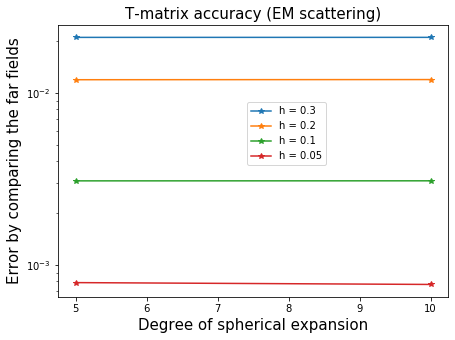

In [36]:
x_axis = [5, 10]
h_03 = [0.02103233370311101, 0.021038768058860537]
h_02 = [0.011922740684476529, 0.011947917119919034]
h_01 = [0.0030739694830646284, 0.0030758692166139444]
h_005 = [0.0007860563191714933, 0.0007669437682187564]

fig = plt.figure()
plt.figure(figsize = (7,5))
plt.semilogy(x_axis,h_03,'*-')
plt.semilogy(x_axis,h_02,'*-')
plt.semilogy(x_axis,h_01,'*-')
plt.semilogy(x_axis,h_005,'*-')

plt.legend(['h = 0.3','h = 0.2','h = 0.1','h = 0.05'],  bbox_to_anchor=(0.7,0.6))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy (EM scattering)',fontsize = 15)
plt.savefig('EM T matrix accuracy deg5and10.pdf',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

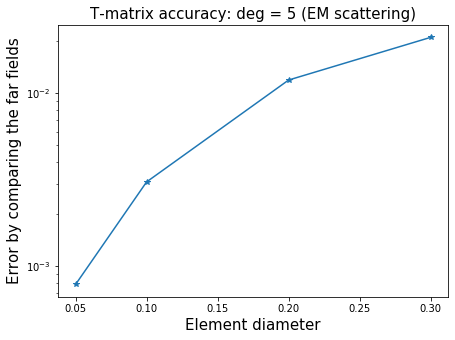

In [37]:
fig = plt.figure()
plt.figure(figsize = (7,5))
plt.semilogy([0.3,0.2,0.1,0.05],[h_03[0], h_02[0], h_01[0], h_005[0]],'*-')
plt.xlabel('Element diameter',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy: deg = 5 (EM scattering)',fontsize = 15)
plt.savefig('EM T matrix accuracy deg5.pdf',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

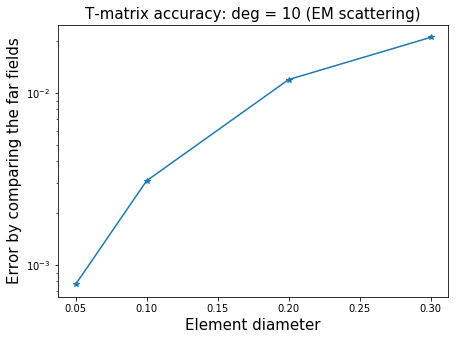

In [38]:
fig = plt.figure()
plt.figure(figsize = (7,5))
plt.semilogy([0.3,0.2,0.1,0.05],[h_03[1], h_02[1], h_01[1], h_005[1]],'*-')
plt.xlabel('Element diameter',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy: deg = 10 (EM scattering)',fontsize = 15)
plt.savefig('EM T matrix accuracy deg10.pdf',bbox_inches='tight')